<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/example%20NN%20GCN%20GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подвиды графовых подходов:
1. Graph-based (например, CF без признаков, user-item)
2. Social graphs (user-user)
3. Knowledge-graph (например, CF с признаками, entities-relations)

Рассмотрим на примере GCN https://arxiv.org/pdf/1609.02907.pdf.

# Пример как задать простой граф


Graph Nodes:  [(0, {'name': 0}), (1, {'name': 1}), (2, {'name': 2}), (3, {'name': 3}), (4, {'name': 4}), (5, {'name': 5})]


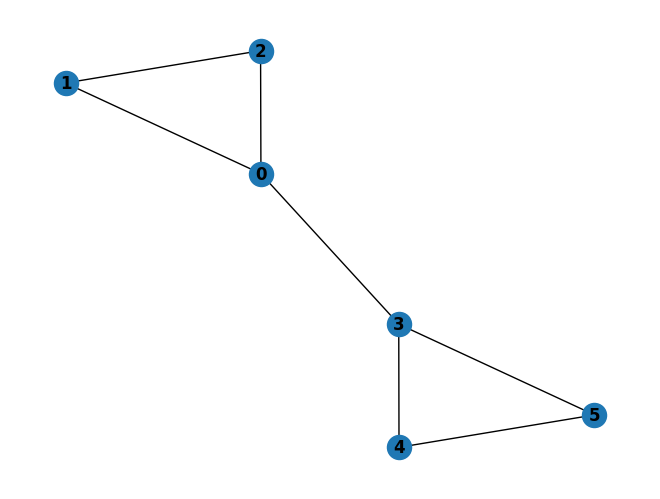

In [124]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


G = nx.Graph(name='G')

for i in range(6):
    G.add_node(i, name=i)

edges = [(0,1),(0,2),(1,2),(0,3),(3,4),(3,5),(4,5)]
G.add_edges_from(edges)

print('\nGraph Nodes: ', G.nodes.data())

nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

Получим Adjacency Matrix (A) и матрицу фичей вершин (X):

In [125]:
A = np.array(nx.attr_matrix(G, node_attr='name')[0])
X = np.array(nx.attr_matrix(G, node_attr='name')[1])
X = np.expand_dims(X,axis=1)

print('Shape of A: ', A.shape)
print('\nShape of X: ', X.shape)
print('\nAdjacency Matrix (A):\n', A)
print('\nNode Features Matrix (X):\n', X)

Shape of A:  (6, 6)

Shape of X:  (6, 1)

Adjacency Matrix (A):
 [[0. 1. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1. 0.]]

Node Features Matrix (X):
 [[0]
 [1]
 [2]
 [3]
 [4]
 [5]]


In [ ]:
AX = np.dot(A,X)
print("Dot product of A and X (AX):\n", AX)

Dot product of A and X (AX):
 [[6.]
 [2.]
 [1.]
 [9.]
 [8.]
 [7.]]


AX представляет собой сумму признаков соседних узлов.

Но! Учитываем ли мы тут признаки самой вершины? Можно добавить петли каждой вершины (диагональ единиц).

In [ ]:
G_self_loops = G.copy()

self_loops = []
for i in range(G.number_of_nodes()):
    self_loops.append((i,i))

G_self_loops.add_edges_from(self_loops)

print('Edges of G with self-loops:\n', G_self_loops.edges)

A_hat = np.array(nx.attr_matrix(G_self_loops, node_attr='name')[0])
print('Adjacency Matrix of added self-loops G (A_hat):\n', A_hat)

AX = np.dot(A_hat, X)
print('AX:\n', AX)

Edges of G with self-loops:
 [(0, 1), (0, 2), (0, 3), (0, 0), (1, 2), (1, 1), (2, 2), (3, 4), (3, 5), (3, 3), (4, 5), (4, 4), (5, 5)]
Adjacency Matrix of added self-loops G (A_hat):
 [[1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]]
AX:
 [[ 6.]
 [ 3.]
 [ 3.]
 [12.]
 [12.]
 [12.]]


Есть еще одна проблема - элементы AX ненормализованы. Подобно предварительной обработке данных для любой операции нейронных сетей, нам необходимо нормализовать функции, чтобы предотвратить вычислительную нестабильность и исчезающие/взрывающиеся градиенты, чтобы модель сходилась.
В GCN, мы нормализуем данные путем вычисления матрицы из степеней вершин (D) и выполнения операции скалярного произведения обратной матрицы D с AX.

In [ ]:
Deg_Mat = G_self_loops.degree()
print('Degree Matrix of added self-loops G (D): ', Deg_Mat)

D = np.diag([deg for (n,deg) in list(Deg_Mat)])
print('Degree Matrix of added self-loops G as numpy array (D):\n', D)

D_inv = np.linalg.inv(D)
print('Inverse of D:\n', D_inv)

DAX = np.dot(D_inv,AX)
print('DAX:\n', DAX)

Degree Matrix of added self-loops G (D):  [(0, 5), (1, 4), (2, 4), (3, 5), (4, 4), (5, 4)]
Degree Matrix of added self-loops G as numpy array (D):
 [[5 0 0 0 0 0]
 [0 4 0 0 0 0]
 [0 0 4 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 4 0]
 [0 0 0 0 0 4]]
Inverse of D:
 [[0.2  0.   0.   0.   0.   0.  ]
 [0.   0.25 0.   0.   0.   0.  ]
 [0.   0.   0.25 0.   0.   0.  ]
 [0.   0.   0.   0.2  0.   0.  ]
 [0.   0.   0.   0.   0.25 0.  ]
 [0.   0.   0.   0.   0.   0.25]]
DAX:
 [[1.2 ]
 [0.75]
 [0.75]
 [2.4 ]
 [3.  ]
 [3.  ]]


Узел 3 имеет 3 инцидентных ребра (не учитываем саму вершину), а узлы 4 и 5 имеют только 2 инцидентных ребра. То, что узел 3 имеет более высокую степень, чем узлы 4 и 5, приводит к более низкому весу функций узла 3 в DAX. Другими словами, чем ниже степень узла, тем сильнее принадлежность узла к определенной группе или кластеру.

Посмотрим на 4-ю ноду до и после нормализации. В чем странность?

In [ ]:
print(AX)
print(DAX)

[[ 6.]
 [ 3.]
 [ 3.]
 [12.]
 [12.]
 [12.]]
[[1.2 ]
 [0.75]
 [0.75]
 [2.4 ]
 [3.  ]
 [3.  ]]


В пространственной свертке (**Spatial Convolution**) мы делаем операции на локальной окрестности соседей вершины и обобщаем информацию о вершине на основании аггрегаций по ним.

### Простые GNN (Graph Neural Networks)

Идея: просто усреднять информацию по соседям.

Сводим задачу к node/edge classification

Для каждой вершины зададим вектор, который будет состоять из $f$ признаков вершины:

$$h^0_f = x_f$$

Используем самый простой способ аггрегации:

$$h^k_f = \sigma ( w^k_1 \sum_{u \in N(f)} \frac{h^{k-1}_u}{\sqrt |N(u)|} + w^k_2 h^{k-1}_f)$$

Итоговый вектор:

$$z_f = h^k_f$$


Посмотрим на разные подходы:

**Simple neighborhood average aggregation (in GNN)**:

$$h^k_f = \sigma ( w^k_1 \sum_{u \in N(f)} \frac{h^{k-1}_u}{\sqrt |N(u)|} + w^k_2 h^{k-1}_f)$$

**GCN**:

$$h^k_f = \sigma ( w^k_1 \sum_{u \in N(f)} \frac{h^{k-1}_u}{\sqrt |N(f)| |N(u)|} + w^k_2 h^{k-1}_f)$$

**GraphSAGE (generalized aggregation)**:

$$h^k_f = \sigma ([w^k_1  \cdot AGG({h^{k-1}_u, \forall_u \in N(u)}, w^k_2 \cdot  h^k_f]) $$

Под AGG может быть mean, pooling, LSTM, attention и др.

**GAT**:


$$h^k_f = \sigma  ( \sum_{u \in N(f)} \alpha_{f, u} w^k h^{k-1}_u)$$


Есть важное накладываемое требование на фукнции аггрегации!

**- Какие возможно еще аггрегации по графу?**

- GraphPooling
- SortPool
- SAGPool
- DiffPool

In [2]:
import warnings
warnings.filterwarnings('ignore')

import torch
torchversion = '2.1.0+cu118'

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import numpy as np
np.random.seed(0)

import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE

In [3]:
!pip install -q torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.3 MB/s eta 0:00:00


# Пример 2 - типовой датасет Planetoid

In [5]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import remove_isolated_nodes, to_networkx, degree

dataset = Planetoid(root=".", name="CiteSeer")

data = dataset[0]

print(f'# графов: {len(dataset)}')
print(f'# вершин: {data.x.shape[0]}')
print(f'# признаков: {dataset.num_features}')
print(f'# классов: {dataset.num_classes}')

print(f'\nGraph:')
print('------')
print(f'Орграф: {data.is_directed()}')
print(f'Есть изолированные вершины: {data.has_isolated_nodes()}')
print(f'Есть петли: {data.has_self_loops()}')

isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Число изолированных вершин = {isolated}')

Processing...


# графов: 1
# вершин: 3327
# признаков: 3703
# классов: 6

Graph:
------
Орграф: False
Есть изолированные вершины: True
Есть петли: False
Число изолированных вершин = 48


Done!


In [20]:
data = dataset[0]

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

# Пример 3 - сами задаем датасет

In [14]:
from torch_geometric.utils import from_networkx, to_networkx

In [129]:
# 'A' is the adjacency matrix, it contains 1 at a position (i,j) if there is a edge between the node i and node j.
A=torch.Tensor([[0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0],
                [1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0],
                [1,1,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0],
                [1,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1],
                [0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1],
                [0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,1,0,1],
                [0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,0]
                ])

In [185]:
#In this example we have the label for admin(node 1)
#and instructor(node 34) so only these two contain
#the class label(0 and 1)

target=torch.tensor([0,1,1,1, 1, 1, 1, 1,1,1,1,1, 1, 0, 1, 1,1,1,1,1, 0, 1, 1, 1,1,1,1,1, 1, 1, 1, 1,1,0])


In [186]:
# X - is a feature matrix
#X=torch.eye(A.size(0))
X=torch.rand(A.size(0),5)
# convert Tensor adjacent matrix to simple numpy array
Anpmat = A.numpy()
G = nx.from_numpy_array(Anpmat)


In [187]:
data = from_networkx(G)
features = X
data.x = torch.tensor(features).float()
data.y = target
data.num_node_features = data.x.shape[-1]
data.num_classes = np.array(list(torch.unique(target).shape))[0]

In [188]:
data

Data(edge_index=[2, 156], weight=[156], num_nodes=34, x=[34, 5], y=[34], num_node_features=5, num_classes=2)

In [216]:
import numpy as np

def create_random_masks(total_nodes, train_percent, test_percent, val_percent):
    """
    Создает случайно распределенные маски для train, test и validation наборов

    Параметры:
    total_nodes (int): Общее количество узлов
    train_percent (float): Процент узлов для обучения (0-1)
    test_percent (float): Процент узлов для тестирования (0-1)
    val_percent (float): Процент узлов для валидации (0-1)

    Возвращает:
    tuple: (train_mask, test_mask, val_mask) - три булевых массива со случайным распределением
    """
    # Проверка корректности процентов
    assert np.isclose(train_percent + test_percent + val_percent, 1.0), \
        "Сумма процентов должна быть равна 1"

    # Создаем массив для хранения всех меток
    labels = np.empty(total_nodes, dtype=np.int8)

    # Вычисляем количество узлов для каждой категории
    train_count = int(train_percent * total_nodes)
    test_count = int(test_percent * total_nodes)
    val_count = total_nodes - train_count - test_count

    # Заполняем массив метками (0 - train, 1 - test, 2 - val)
    labels[:train_count] = 0
    labels[train_count:train_count+test_count] = 1
    labels[train_count+test_count:] = 2

    # Случайно перемешиваем метки
    np.random.shuffle(labels)

    # Создаем булевы маски
    train_mask = (labels == 0)
    test_mask = (labels == 1)
    val_mask = (labels == 2)

    return train_mask, test_mask, val_mask

# Пример использования:
total_nodes = data.x.size()[0]  # Меньшее количество для наглядности
train_percent = 0.7  # 60%
test_percent = 0.2    # 20%
val_percent = 0.1     # 20%

train_mask, test_mask, val_mask = create_random_masks(total_nodes, train_percent, test_percent, val_percent)


data.train_mask = torch.tensor(train_mask, dtype=torch.bool)
data.test_mask = torch.tensor(test_mask, dtype=torch.bool)
data.val_mask = torch.tensor(val_mask, dtype=torch.bool)

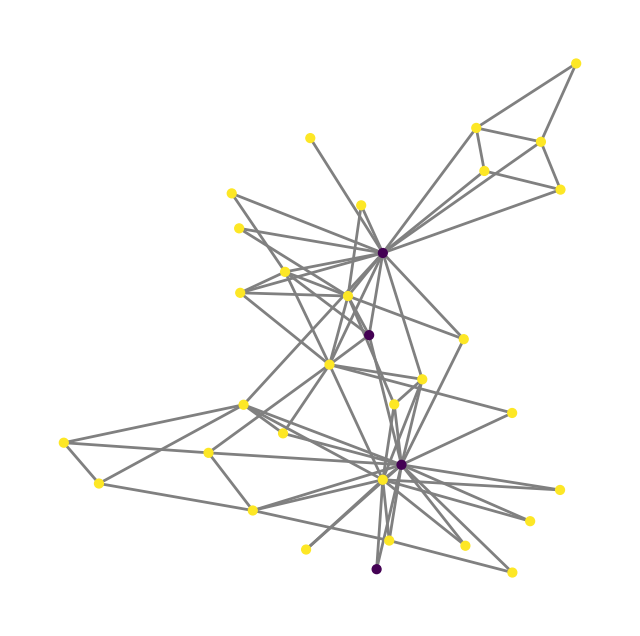

In [217]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(8,8))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=40,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

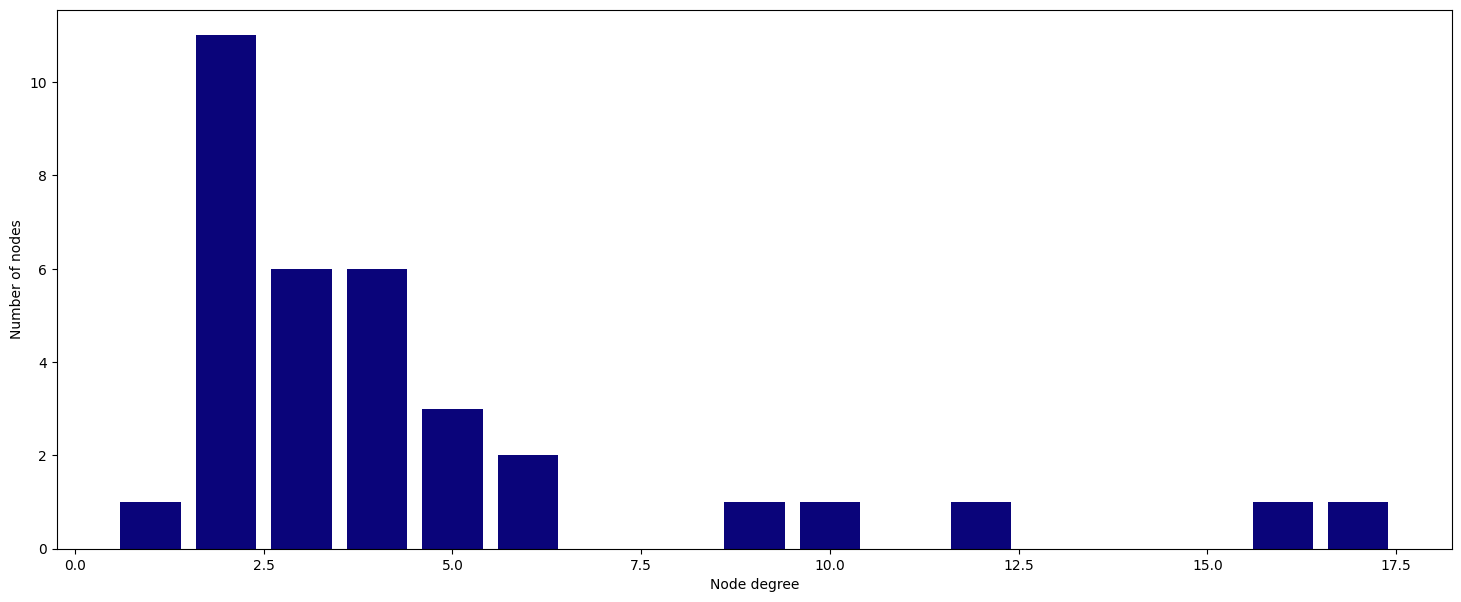

In [218]:
degrees = degree(data.edge_index[0]).numpy()
numbers = Counter(degrees)

fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A');

In [219]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_h)
        self.gcn3 = GCNConv(dim_h, dim_out)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5, training=self.training)
        h = self.gcn1(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        return h, F.log_softmax(h, dim=1)


class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=4):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.005,
                                          weight_decay=5e-4)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(x, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return h, F.log_softmax(h, dim=1)

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 30

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [220]:
%%time

#gcn = GCN(dataset.num_features, 16, dataset.num_classes)
gcn = GCN(data.x.size()[1], 16, dataset.num_classes)
print(gcn)

train(gcn, data)

acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(5, 16)
  (gcn2): GCNConv(16, 16)
  (gcn3): GCNConv(16, 6)
)
Epoch   0 | Train Loss: 2.873 | Train Acc:   0.00% | Val Loss: 2.95 | Val Acc: 0.00%
Epoch  10 | Train Loss: 2.315 | Train Acc:  52.17% | Val Loss: 2.25 | Val Acc: 100.00%
Epoch  20 | Train Loss: 1.639 | Train Acc:  82.61% | Val Loss: 1.45 | Val Acc: 100.00%
Epoch  30 | Train Loss: 0.788 | Train Acc:  82.61% | Val Loss: 0.63 | Val Acc: 100.00%

GCN test accuracy: 100.00%

CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 116 ms


In [221]:
%%time

#gat = GAT(dataset.num_features, 8, dataset.num_classes)
gat = GAT(data.x.size()[1],16, dataset.num_classes)
print(gat)
train(gat, data)
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(5, 16, heads=4)
  (gat2): GATv2Conv(64, 6, heads=1)
)
Epoch   0 | Train Loss: 1.754 | Train Acc:   8.70% | Val Loss: 1.83 | Val Acc: 0.00%
Epoch  10 | Train Loss: 0.587 | Train Acc:  82.61% | Val Loss: 0.21 | Val Acc: 100.00%
Epoch  20 | Train Loss: 0.488 | Train Acc:  82.61% | Val Loss: 0.13 | Val Acc: 100.00%
Epoch  30 | Train Loss: 0.481 | Train Acc:  82.61% | Val Loss: 0.22 | Val Acc: 100.00%

GAT test accuracy: 100.00%

CPU times: user 170 ms, sys: 1.93 ms, total: 172 ms
Wall time: 172 ms


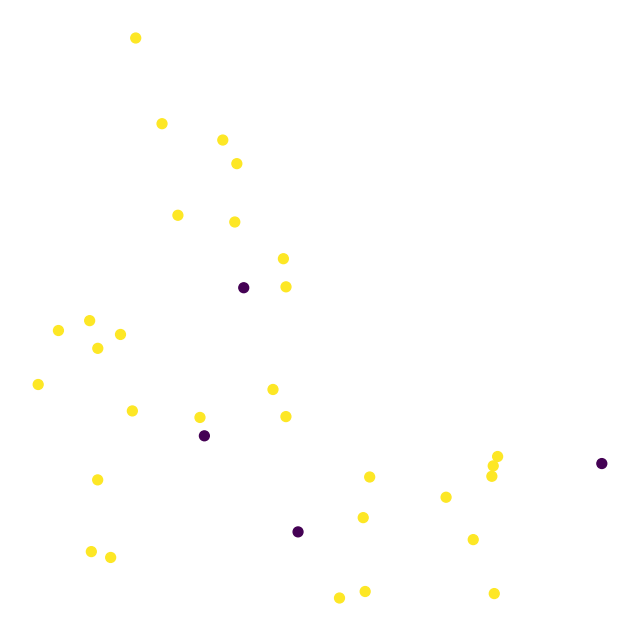

In [222]:
untrained_gat = GAT(data.x.size()[1],16, dataset.num_classes)


# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)


tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

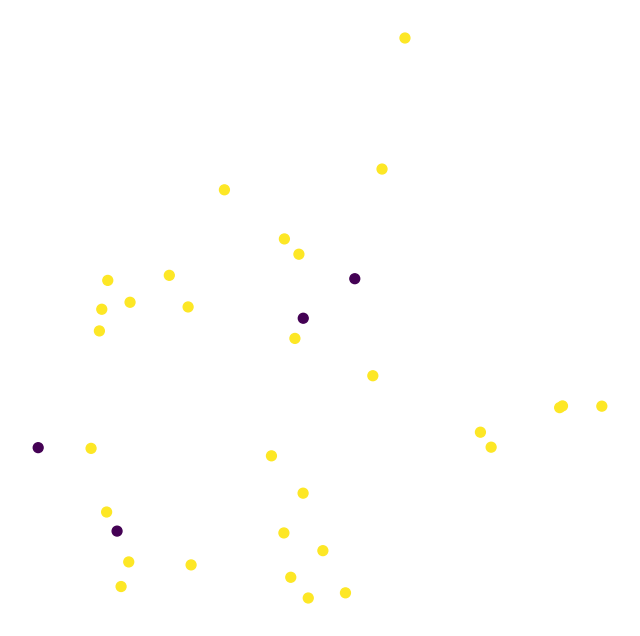

In [223]:
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())


plt.figure(figsize=(8, 8))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

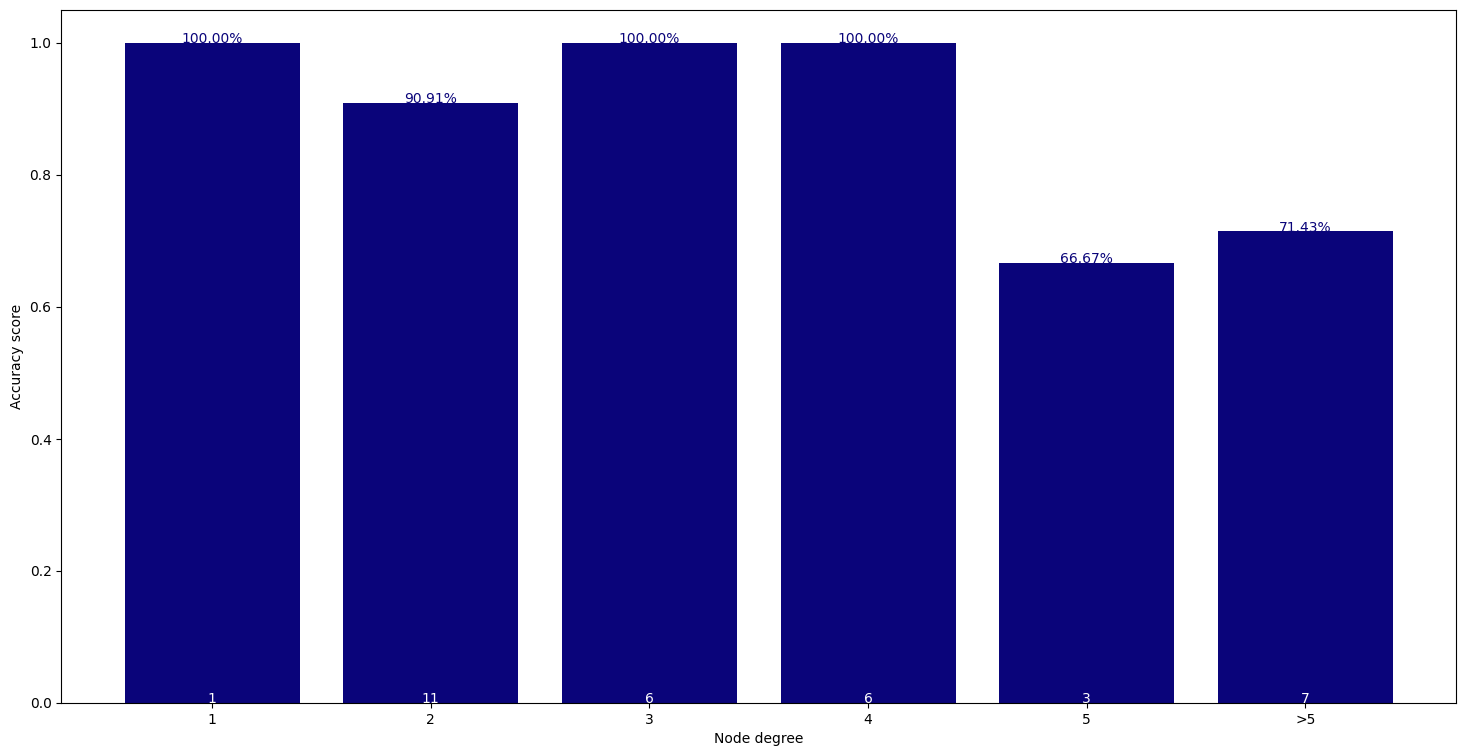

In [224]:
# Get model's classifications
_, out = gat(data.x, data.edge_index)
degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
    sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

fig, ax = plt.subplots(figsize=(18, 9))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','>5'],
    accuracies,
    color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%',
             ha='center', color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i],
             ha='center', color='white')

https://cs.stanford.edu/people/jure/pubs/graphsage-nips17.pdf
